In [36]:
import pandas as pd
import numpy as np
from scipy.io import loadmat  
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.cluster import KMeans


In [37]:
data=pd.read_csv('https://raw.githubusercontent.com/Alexamannn/Critical-Review-of-Statistics-in-Data-Science-and-Machine-Learning/main/Problem1%20%20%20Anomoly%20Detection/logs.csv?token=AOQAGNHRLIH7B4AXJM6R5FLAUZACI')


In [38]:
data['@timestamp'] = pd.to_datetime(data['@timestamp'])
data.sort_values(['ip_address', '@timestamp'], inplace=True)
data['shift_time'] = data.groupby(['ip_address'])['@timestamp'].shift(1)
data['time_diff'] = (data['@timestamp'] - data['shift_time']).dt.seconds//60
data['date'] = data['@timestamp'].dt.date
data['dow'] = data['@timestamp'].dt.weekday
data['hour'] = data['@timestamp'].dt.hour
data['is_weekend'] = ((data['dow']==5)|(data['dow']==6)).astype(int)
data['hour_bucket'] = data['hour']//4
data
databack=data

In [39]:
ip_col = 'ip_address'
ip_counts = data.groupby(ip_col)['@timestamp'].count().reset_index()
ip_counts = ip_counts.rename(columns={'@timestamp':'total_count'})

In [40]:
daily_counts = data.groupby([ip_col, 'date'])['@timestamp'].count().reset_index()
daily_counts = daily_counts.rename(columns={'@timestamp':'daily_counts'})
daily_counts_agg = daily_counts.groupby(ip_col).daily_counts.median().reset_index()

daily_counts_agg

,ip_address,daily_counts
0,10.1.1.1,40.0
1,10.1.1.100,78.0
2,10.1.1.101,40.0
3,10.1.1.106,35.5
4,10.1.1.109,42.5
...,...,...
381,10.1.2.86,111.0
382,10.1.2.89,73.5
383,10.1.2.90,76.0
384,10.1.2.95,77.5


In [41]:
weekend_counts = data.groupby([ip_col, 'is_weekend'])['@timestamp'].count().reset_index()
weekend_counts = weekend_counts.rename(columns={'@timestamp':'weekend_counts'})
weekend_counts_agg = weekend_counts.pivot_table(index=ip_col, columns='is_weekend').reset_index([0])
weekend_counts_agg.columns = weekend_counts_agg.columns.droplevel()
weekend_counts_agg.columns = [ip_col, 'week_day', 'weekend']
weekend_counts_agg['is_weekend_ratio'] = weekend_counts_agg['week_day']/ weekend_counts_agg['weekend']
lean_weekend_counts_agg = weekend_counts_agg[[ip_col, 'is_weekend_ratio']]
avg_timedelta_data = data.groupby(ip_col).agg({'time_diff':['mean','max']}).reset_index()
avg_timedelta_data.columns = avg_timedelta_data.columns.droplevel()
avg_timedelta_data.columns = [ip_col, 'td_mean', 'td_max']
avg_timedelta_data


,ip_address,td_mean,td_max
0,10.1.1.1,28.999308,362.0
1,10.1.1.100,14.427072,185.0
2,10.1.1.101,28.520492,211.0
3,10.1.1.106,29.771144,319.0
4,10.1.1.109,28.711934,278.0
...,...,...,...
381,10.1.2.86,9.441013,122.0
382,10.1.2.89,14.612743,207.0
383,10.1.2.90,14.215639,159.0
384,10.1.2.95,14.407394,188.0


In [42]:
lean_weekend_counts_agg

,ip_address,is_weekend_ratio
0,10.1.1.1,2.070064
1,10.1.1.100,2.177778
2,10.1.1.101,2.191721
3,10.1.1.106,2.229358
4,10.1.1.109,2.206593
...,...,...
381,10.1.2.86,2.209389
382,10.1.2.89,2.196833
383,10.1.2.90,2.334099
384,10.1.2.95,2.204469


In [43]:
merge_1 = ip_counts.merge(daily_counts_agg, on=ip_col, how='left')
merge_2 = merge_1.merge(lean_weekend_counts_agg, on=ip_col, how='left')
data = merge_2.merge(avg_timedelta_data, on=ip_col, how='left')
data

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max
0,10.1.1.1,1446,40.0,2.070064,28.999308,362.0
1,10.1.1.100,2860,78.0,2.177778,14.427072,185.0
2,10.1.1.101,1465,40.0,2.191721,28.520492,211.0
3,10.1.1.106,1408,35.5,2.229358,29.771144,319.0
4,10.1.1.109,1459,42.5,2.206593,28.711934,278.0
...,...,...,...,...,...,...
381,10.1.2.86,4307,111.0,2.209389,9.441013,122.0
382,10.1.2.89,2826,73.5,2.196833,14.612743,207.0
383,10.1.2.90,2904,76.0,2.334099,14.215639,159.0
384,10.1.2.95,2868,77.5,2.204469,14.407394,188.0


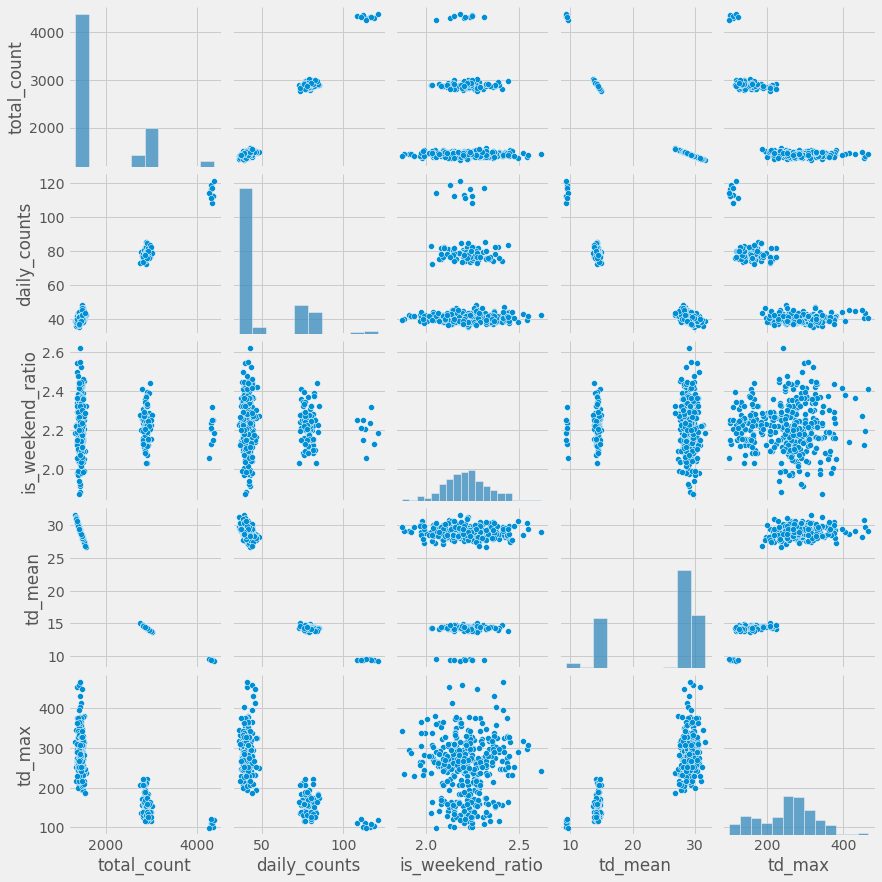

In [44]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
feature_cols = ['total_count', 'daily_counts', 'is_weekend_ratio', 'td_mean', 'td_max']

x=data[['total_count','daily_counts','is_weekend_ratio','td_mean','td_max']]
scaledx = pd.DataFrame(StandardScaler().fit_transform(x), columns=feature_cols)
sns.pairplot(x)


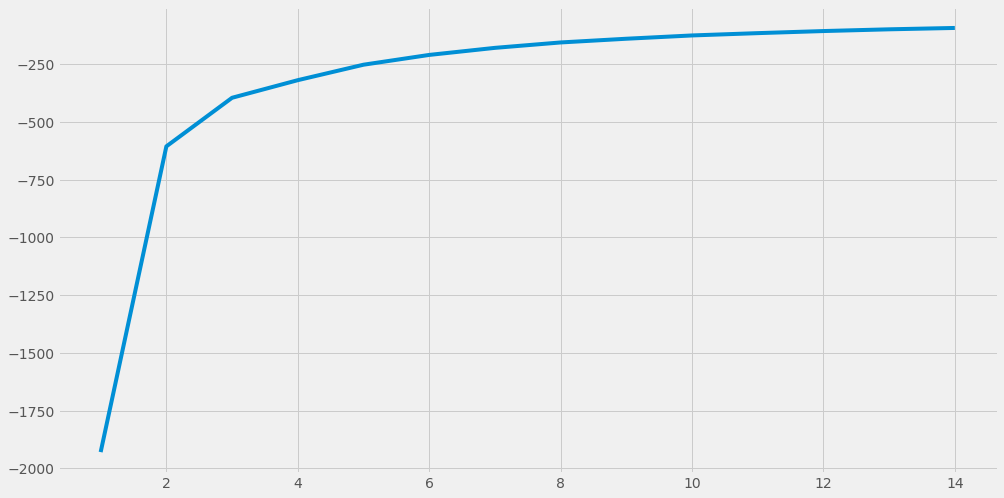

In [45]:
from sklearn.cluster import KMeans
RANDOM_STATE = 123

n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(scaledx) for i in n_cluster]
scores = [kmeans[i].score(scaledx) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [46]:
cluster_model = kmeans[5]
x['cluster'] = cluster_model.predict(scaledx)
x['cluster'].value_counts()

0    101
1     94
5     78
4     61
2     42
3     10
Name: cluster, dtype: int64

In [47]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=RANDOM_STATE)
tsne_results = tsne.fit_transform(scaledx)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 386 samples in 0.000s...
[t-SNE] Computed neighbors for 386 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 386 / 386
[t-SNE] Mean sigma: 0.415830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.996994
[t-SNE] KL divergence after 300 iterations: 0.324114


In [48]:
x['tsne-2d-one'] = tsne_results[:,0]
x['tsne-2d-two'] = tsne_results[:,1]

In [49]:
tsne_cluster = x.groupby('cluster').agg({'tsne-2d-one':'mean', 'tsne-2d-two':'mean'}).reset_index()


In [50]:
tsne_cluster

,cluster,tsne-2d-one,tsne-2d-two
0,0,-3.756793,3.537113
1,1,9.256185,-8.129962
2,2,-4.037342,-0.553785
3,3,6.555386,-2.933407
4,4,-10.505479,-5.366313
5,5,3.382494,10.993628


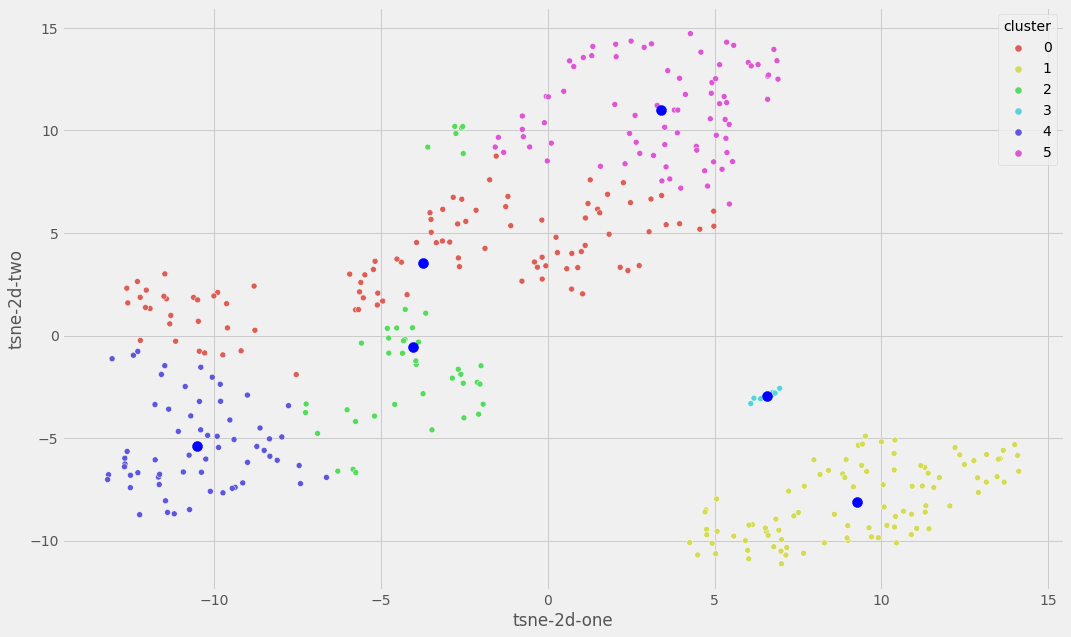

In [51]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    palette=sns.color_palette("hls", 6),
    data=x,
    legend="full",
    alpha=1
)

plt.scatter(x="tsne-2d-one", y="tsne-2d-two", data=tsne_cluster, s=100, c='b')

plt.show()

In [52]:
centers = cluster_model.cluster_centers_
points = np.asarray(scaledx)
total_distance = pd.Series()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
x['2norm'] =0 

#plt.hist(x['ssd'], bins=100)


In [54]:
centers = cluster_model.cluster_centers_
points = np.asarray(scaledx[feature_cols])
for m in range(len(points)):
        distance = 0
        for j in range(len(centers)):
            a = np.linalg.norm(points[m] - centers[j])
            distance += a**2
            x['2norm'][m]=distance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
x

,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,2norm
0,1446,40.0,2.070064,28.999308,362.0,5,1.062182,13.558432,88
1,2860,78.0,2.177778,14.427072,185.0,1,7.217216,-7.587181,72
2,1465,40.0,2.191721,28.520492,211.0,0,2.399300,3.168043,63
3,1408,35.5,2.229358,29.771144,319.0,2,-4.284939,-0.191083,74
4,1459,42.5,2.206593,28.711934,278.0,0,-3.160389,4.609698,62
...,...,...,...,...,...,...,...,...,...
381,4307,111.0,2.209389,9.441013,122.0,3,6.610925,-2.915438,183
382,2826,73.5,2.196833,14.612743,207.0,1,7.974759,-6.061185,66
383,2904,76.0,2.334099,14.215639,159.0,1,12.771983,-6.103673,81
384,2868,77.5,2.204469,14.407394,188.0,1,8.159006,-6.778321,71


(array([ 4., 11., 15., 17., 32., 25., 27., 12., 22., 10., 22.,  8., 22.,
        12., 30.,  4., 30.,  3.,  9., 13.,  7.,  5.,  8.,  2.,  2.,  0.,
         3.,  0.,  5.,  3.,  1.,  2.,  1.,  0.,  2.,  0.,  2.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.]),
 array([ 58.  ,  59.49,  60.98,  62.47,  63.96,  65.45,  66.94,  68.43,
         69.92,  71.41,  72.9 ,  74.39,  75.88,  77.37,  78.86,  80.35,
         81.84,  83.33,  84.82,  86.31,  87.8 ,  89.29,  90.78,  92.27,
         93.76,  95.25,  96.74,  98.23,  99.72, 101.21, 102.7 , 104.19,
        105.68, 107.17, 108.66, 110.15, 111.64, 113.13, 114.62, 116.11,
        117.6 , 119.09, 120.58, 122.07, 123.56, 125.05, 126.54, 128.03,
  

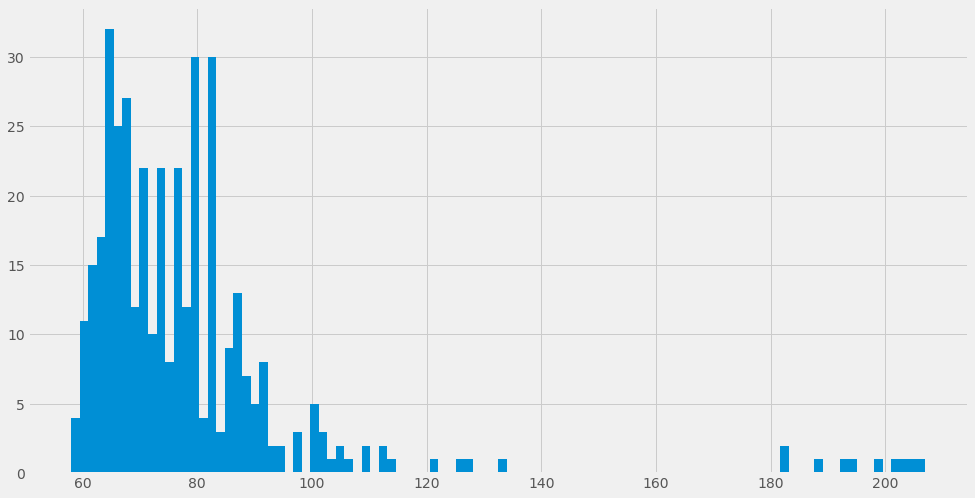

In [56]:
plt.hist(x['2norm'], bins=100)


In [57]:
cutoff = 110
x['anomaly_kmeans'] = (x['2norm'] >= cutoff).astype(int)


In [58]:
x=x.join(data['ip_address'])
x

,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,2norm,anomaly_kmeans,ip_address
0,1446,40.0,2.070064,28.999308,362.0,5,1.062182,13.558432,88,0,10.1.1.1
1,2860,78.0,2.177778,14.427072,185.0,1,7.217216,-7.587181,72,0,10.1.1.100
2,1465,40.0,2.191721,28.520492,211.0,0,2.399300,3.168043,63,0,10.1.1.101
3,1408,35.5,2.229358,29.771144,319.0,2,-4.284939,-0.191083,74,0,10.1.1.106
4,1459,42.5,2.206593,28.711934,278.0,0,-3.160389,4.609698,62,0,10.1.1.109
...,...,...,...,...,...,...,...,...,...,...,...
381,4307,111.0,2.209389,9.441013,122.0,3,6.610925,-2.915438,183,1,10.1.2.86
382,2826,73.5,2.196833,14.612743,207.0,1,7.974759,-6.061185,66,0,10.1.2.89
383,2904,76.0,2.334099,14.215639,159.0,1,12.771983,-6.103673,81,0,10.1.2.90
384,2868,77.5,2.204469,14.407394,188.0,1,8.159006,-6.778321,71,0,10.1.2.95


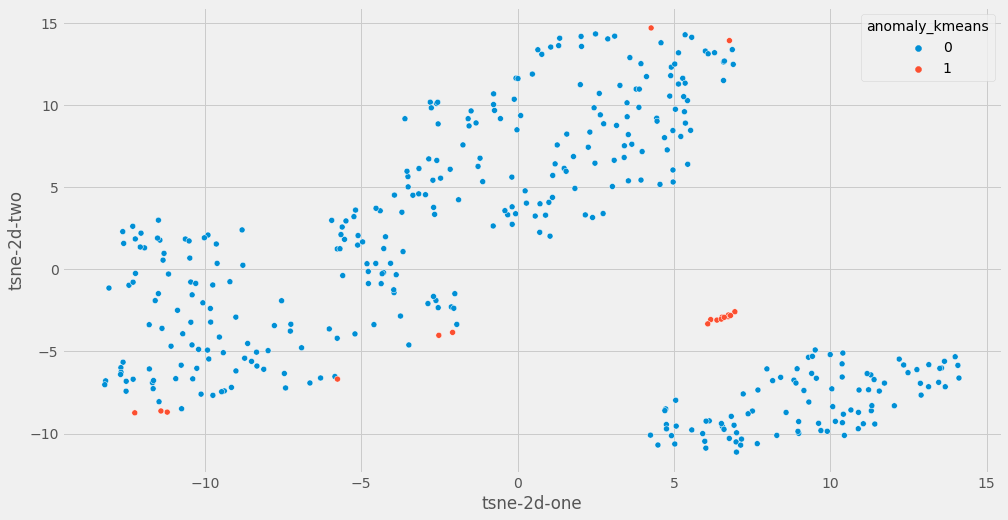

In [59]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_kmeans",
    data=x,
    legend="full",
    alpha=1
)

In [60]:
anomolies=x.loc[x['anomaly_kmeans']==1]
anomolies

,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,2norm,anomaly_kmeans,ip_address
14,1383,39.5,2.546154,30.306078,297.0,4,-11.403841,-8.626899,113,1,10.1.1.138
42,1365,40.5,2.123570,30.801320,455.0,2,-2.076416,-3.836896,121,1,10.1.1.199
62,4301,116.5,2.236268,9.459535,101.0,3,6.737013,-2.875531,199,1,10.1.1.249
70,1445,42.5,2.621554,29.042936,241.0,4,-12.239997,-8.738975,128,1,10.1.1.264
118,4300,118.5,2.127273,9.453361,104.0,3,6.177608,-3.054615,205,1,10.1.1.386
136,1438,40.0,1.881764,29.170494,235.0,5,6.776437,13.952807,110,1,10.1.1.427
164,4317,117.0,2.315668,9.417285,108.0,3,6.950425,-2.575877,202,1,10.1.1.486
177,4339,112.0,2.148766,9.368142,101.0,3,6.377236,-3.085320,195,1,10.1.1.63
188,4293,113.0,2.203731,9.456897,110.0,3,6.542520,-2.906541,189,1,10.1.1.86
253,1407,39.5,1.871429,29.747511,343.0,5,4.272238,14.723619,126,1,10.1.2.243


In [61]:
databack.loc[databack['ip_address']=='10.1.2.323']

,Unnamed: 0,@timestamp,_id,ip_address,shift_time,time_diff,date,dow,hour,is_weekend,hour_bucket
720237,720237,2019-06-09 01:49:09,NknsOWsBoTGddM7vzikK,10.1.2.323,NaT,NaN,2019-06-09,6,1,1,0
719957,719957,2019-06-09 02:12:29,sSACOmsB7mP0GwVzLh-2,10.1.2.323,2019-06-09 01:49:09,23.0,2019-06-09,6,2,1,0
718899,718899,2019-06-09 03:40:39,oCNSOmsB7mP0GwVz5j3E,10.1.2.323,2019-06-09 02:12:29,88.0,2019-06-09,6,3,1,0
718893,718893,2019-06-09 03:41:09,601TOmsBoTGddM7vWy7x,10.1.2.323,2019-06-09 03:40:39,0.0,2019-06-09,6,3,1,0
718686,718686,2019-06-09 03:58:25,l01jOmsBoTGddM7vKsjR,10.1.2.323,2019-06-09 03:41:09,17.0,2019-06-09,6,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1538,1538,2019-07-08 12:59:19,18Wq0WsBoTGddM7vzFlE,10.1.2.323,2019-07-08 12:15:07,44.0,2019-07-08,0,12,0,3
1054,1054,2019-07-08 13:19:29,H5690WsB7mP0GwVzQ4wn,10.1.2.323,2019-07-08 12:59:19,20.0,2019-07-08,0,13,0,3
1000,1000,2019-07-08 13:21:45,DMa_0WsBoTGddM7vVuEU,10.1.2.323,2019-07-08 13:19:29,2.0,2019-07-08,0,13,0,3
970,970,2019-07-08 13:22:59,rMbA0WsBoTGddM7vd_Yl,10.1.2.323,2019-07-08 13:21:45,1.0,2019-07-08,0,13,0,3
